# Aprendizaje Automático

## Práctica 8: Ensembles, One-vs-One y One-vs-All

En esta práctica vamos a trabajar con los modelos basados en ensembles: Bagging, Boosting y RandomForest, además de las descomposiciones OVO y OVA para problemas multi-clase. Comenzaremos visualizando el comportamiento de Bagging, Boosting y las estrategias de descomposición y terminaremos buscando el mejor modelo para una serie de conjuntos de datos.


## Índice de la práctica

- [Visualizando Adaboost con decision stumps](#Visualizando-Adaboost-con-decision-stumps)
- [Visualizando Bagging con decision stumps](#Visualizando-Bagging-con-decision-stumps)
- [Visualizando OVA y OVO](#Visualizando-OVA-y-OVO)
- [Comparativa DecisionTree, Bagging, Boosting y Random Forest](#Comparativa-DecisionTree,-Bagging,-Boosting-y-Random-Forest)
- [Parte opcional: Implementación de Adaboost con Decision Stumps desde 0](#opcional) 

Importamos todas las librerías que vamos a utilizar inicialmente. Posteriormente iremos importando las librerías específicas de cada apartado de la práctica.

In [1]:
import dataset as ds
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import metrics

# Helper function to test the correctness of the solutions
def test_nb(var, val, msg=""):
    if var == val:
        print("✔️ Test passed.")
    else:
        print("❌ Test failed. " + msg)
        raise AssertionError(msg)


%matplotlib inline

## Visualizando Adaboost con decision stumps

En esta práctica vamos a analizar el comportamiento de los ensembles de clasificadores. En primer lugar vamos a analizar el comportamiento del algoritmo AdaBoost junto con el clasificador Decision Stump (árbol de decisión de un solo nivel) como clasificador base. 

La librería scikit-learn (sklearn) nos ofrece una clase para utilizar el algoritmo AdaBoost. Esta clase se llama `AdaBoostClassifier` y está dentro de la librería ensemble. Toda la información de esta clase se puede encontrar en el siguiente [enlace](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier). Para utilizar dicha clase lo primero que tenemos que hacer es importarla

    from sklearn.ensemble import AdaBoostClassifier
    
La llamada al constructor y sus principales parámetros de entrada son los siguientes:

    AdaBoostClassifier(estimator=clasificador_base, n_estimators=numero_clasificadores_base, random_state=semilla)

Los parámetros de entrada son:
* `clasificador_base`: objeto de una clase correspondiente a un clasificador. Por defecto se utilizan los árboles de decisión: `DecisionTreeClassifier`. 
* `numero_clasificadores_base`: valor entero que determina el número de clasificadores que compondrán el ensemble. Por defecto es 50.
* `semilla`: valor que determina la semilla para la generación de números aleatorios.

Para visualizar el comportamiento de AdaBoost vamos a **simular los Decision Stumps** mediante árboles de decisión con un solo nodo interno (nodo raíz, profundidad igual a 1). Para poder utilizarlos debemos importar la clase correspondiente a los árboles de decisión

    from sklearn.tree import DecisionTreeClassifier
    
Tal y como hemos mencionado, deberemos establecer que la profundidad máxima de los árboles generados sea 1. Por tanto, en la llamada al constructor deberemos establecer el parámetro `max_depth` a 1. Además, en este caso utilizaremos el `criterion` a `'entropy'`.

    DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [2]:
# Se importan las librerías de AdaBoost y de árboles de decisión 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


Para mostrar el comportamiento de los Decisión Stumps y del ensemble construido vamos a crear un dataset sintético. Para ello vamos a utilizar la función `make_gaussian_quantiles` de la librería datasets. Toda la información de esta función el siguiente [enlace](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_gaussian_quantiles.html#sklearn.datasets.make_gaussian_quantiles). Para poder utilizarla, en primer lugar debemos importarla.

    from sklearn.datasets import make_gaussian_quantiles

Esta función permite crear conjuntos de ejemplos sintéticos que sigan distribuciones normales y permite establecer el número de variables de entrada, de clases y de ejemplos a crear. La llamada a la función y sus principales parámetros de entrada y salida son los siguientes:

    X, y = make_gaussian_quantiles(mean=media_distribución, cov=desviacion, n_samples=numero_ejemplos, n_features=numero_variables, n_classes=numero_clases, random_state=semilla)

Los parámetros de entrada son:
* `media_distribución`: array de tantos valores reales como variables. Cada valor representa la media de la distribución normal para esa variable. Por defecto, el valor asignado es `None` que significa que todas las variables tienen media 0.0.
* `desviacion`: array de tantos valores reales como variables. Cada valor representa la desviación estándar de la distribución normal para esa variable. La matriz de covarianza será la matriz identidad multiplicada por este valor. Por defecto, el valor asignado es 1.0.
* `numero_ejemplos`: valor entero que determina el número de ejemplos a generar. Por defecto es 100.
* `numero_variables`: valor entero que determina el número de variables a generar. Por defecto es 2.
* `numero_clases`: valor entero que determina el número de clases a generar. Por defecto es 3.
* `semilla`: valor que determina la semilla para la generación de números aleatorios.

Los parámetros de salida son:
* `X`: los valores de  variables de entrada de los ejemplos generados.
* `y`: las clases de los ejemplos generados.

Vamos a generar un dataset con dos zonas de ejemplos. Es decir, vamos a crear dos conjuntos de ejemplos que sigan dos distribuciones normales diferentes. Los valores de los parámetros de ambas distribuciones (comunes a todas las variables) son los siguientes:
* **Distribución 1**
    * media: 0.0
    * desviación: 2.0
    * 200 ejemplos
    * 2 variables
    * 2 clases
    * semilla: valor 1
* **Distribución 2**
    * media: 3.0
    * desviación: 1.5
    * 200 ejemplos
    * 2 variables
    * 2 clases
    * semilla: valor 1

In [3]:
# Importamos la funcionalidad para generar datasets sintéticos con distribuciones gaussianas 
from sklearn.datasets import make_gaussian_quantiles
# Generamos la primera distribución de ejemplos y la almacenamos en X1, y1
X1, y1 = make_gaussian_quantiles(mean=None, cov=2.0, n_samples = 200, n_features=2, n_classes=2, random_state=1)
# Generamos la segunda distribución de ejemplos y la almacenamos en X2, y2
X2, y2 = make_gaussian_quantiles(mean=(3.0,3.0), cov=1.5, n_samples = 200, n_features=2, n_classes=2, random_state=1)


A continuación vamos a unir ambas distribuciones de ejemplos en una sola para, de esta forma, generar el dataset. Para ello se utiliza la función `concatenate` o `vstack` de numpy (concatena las variables deseadas, que son pasadas como una tupla).

Por defecto, los ejemplos generados siguen una distribución normal y son creados de tal forma que a los más cercanos a la media se les asigna como clase el valor 1 y a los más lejanos se les asigna como clase el valor 0. Para hacer el problema más complejo, a la segunda distribución de ejemplos vamos a cambiarles las clases de tal forma que la clase 0 pase a ser la clase 1 y viceversa. Para ello, debes restar 1 a las clases de la segunda distribución y hacer el valor absoluto (función `abs` de numpy).

In [4]:
# Se concatenan las variables de entrada X1 y X2 y las almacenamos en X
X = np.concatenate([X1,X2]) ##400,2
# Se concatenan las clases de salida y las almacenamos en y
y = np.concatenate([y1,np.abs(y2-1)])

In [5]:
# Se realiza la comprabación de la corrección en la generación de las clases
comprobacion_clases = (np.concatenate((y[:5],y[-5:]))==[0, 1, 1, 1, 1, 1, 1, 0, 0, 1]).all()
test_nb(comprobacion_clases, True, 'Valores de las clases incorrectos')

✔️ Test passed.


Ahora vamos a crear una función que nos permitirá mostrar los ejemplos de entrenamiento en una gráfica 2D y dibujar las fronteras de decisión en caso de pasar un clasificador de scikit como tercer parámetro. Podemos también pasar el título de la figura si queremos como cuarto parámetro.

In [6]:
def mostrar(X, y, clasificador=None, title=None, ax=None):
    """
    Esta función muestra las fronteras de decisión del clasificador ya entrenado y los ejemplos en X
    (con el color dependiendo de y).
    :param clasificador: Clasificador entrenado de scikit-learn
    :param X: Matriz con los ejemplos a mostrar
    :param y: Vector con las salidas de los ejemplos a mostrar
    :return: Nada
    """
    # Creamos los mapas de colores a utilizar
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#FFFF00', '#0000FF'])

    if ax is None:
        # Creamos la figura
        fig, ax = plt.subplots(figsize=(10, 8))
    
    if clasificador is not None:
        # Preparamos los ejemplos de entrada para poder pintar la frontera de decisión
        # Asignamos una clase (color) a cada ejemplo de la malla en [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X[:, 0].min() * 0.9-0.05, X[:, 0].max() * 1.1
        y_min, y_max = X[:, 1].min() * 0.9-0.05, X[:, 1].max() * 1.1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))

        # Clasificamos los puntos
        Z = clasificador.predict(np.c_[xx.ravel(), yy.ravel()])
        # Ponemos el resultado en el formato deseado
        Z = Z.reshape(xx.shape)

        # Pintamos las fronteras
        ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    
    # Pintamos los puntos
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=60)
    # Asignamos el título
    ax.set_xlabel('Variable 1')
    ax.set_ylabel('Variable 2')
    if title is None:
        ax.set_title("Ejemplos de Train")
    else:
        # Establecemos el título recibido como parámetro
        ax.set_title(title)
            
    
    if clasificador is not None:
        # Establecemos los límites
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    return

Utiliza la función mostrar para ver el dataset que acabas de crear.

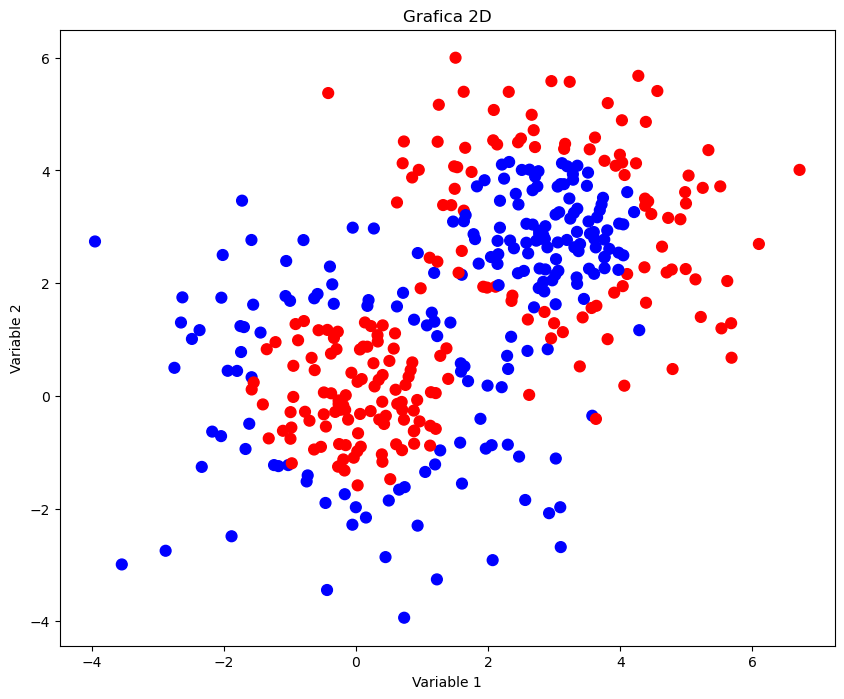

In [7]:
mostrar(X, y,title="Grafica 2D")

Una vez generado el dataset, vamos a crear y entrenar el ensemble de clasificadores con la técnica AdaBoost. 

Se debe comprobar el comportamiento al utilizar 5 y 7 clasificadores base (Decision Stumps). Para ello, **ejecutar dos veces las dos celdas de código siguientes, cambiando el número de clasificadores base del ensemble**. Utiliza la semilla 12 para AdaBoost.

In [11]:
# Se define el número de clasificadores base de AdaBoost (num_clasificadores_base)
num_clasificadores_base = 7
# Llamada al constructor del clasificador AdaBoost con decision stumps (DecisionTree con profundidad 1)
# No te preocupes si aparece un warning sobre el algoritmo a utilizar
tree = DecisionTreeClassifier(criterion='entropy',max_depth=1)
adaboost = AdaBoostClassifier(estimator=tree,n_estimators=num_clasificadores_base,random_state=12)
# Entrenamiento del clasificador creado
adaboost.fit(X,y)


/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=1),
                   n_estimators=7, random_state=12)

Una vez entrenado (generado) el modelo vamos a mostrar gráficamente el comportamiento del mismo. Para ello, vamos a crear tantas gráficas como clasificadores base para mostrar la superficie de decisión de cada Decision Stump y otra más en la que mostraremos la superficie de decisión del ensemble.

[57.5, 62.0, 57.25, 55.25, 62.5, 56.0, 56.25]


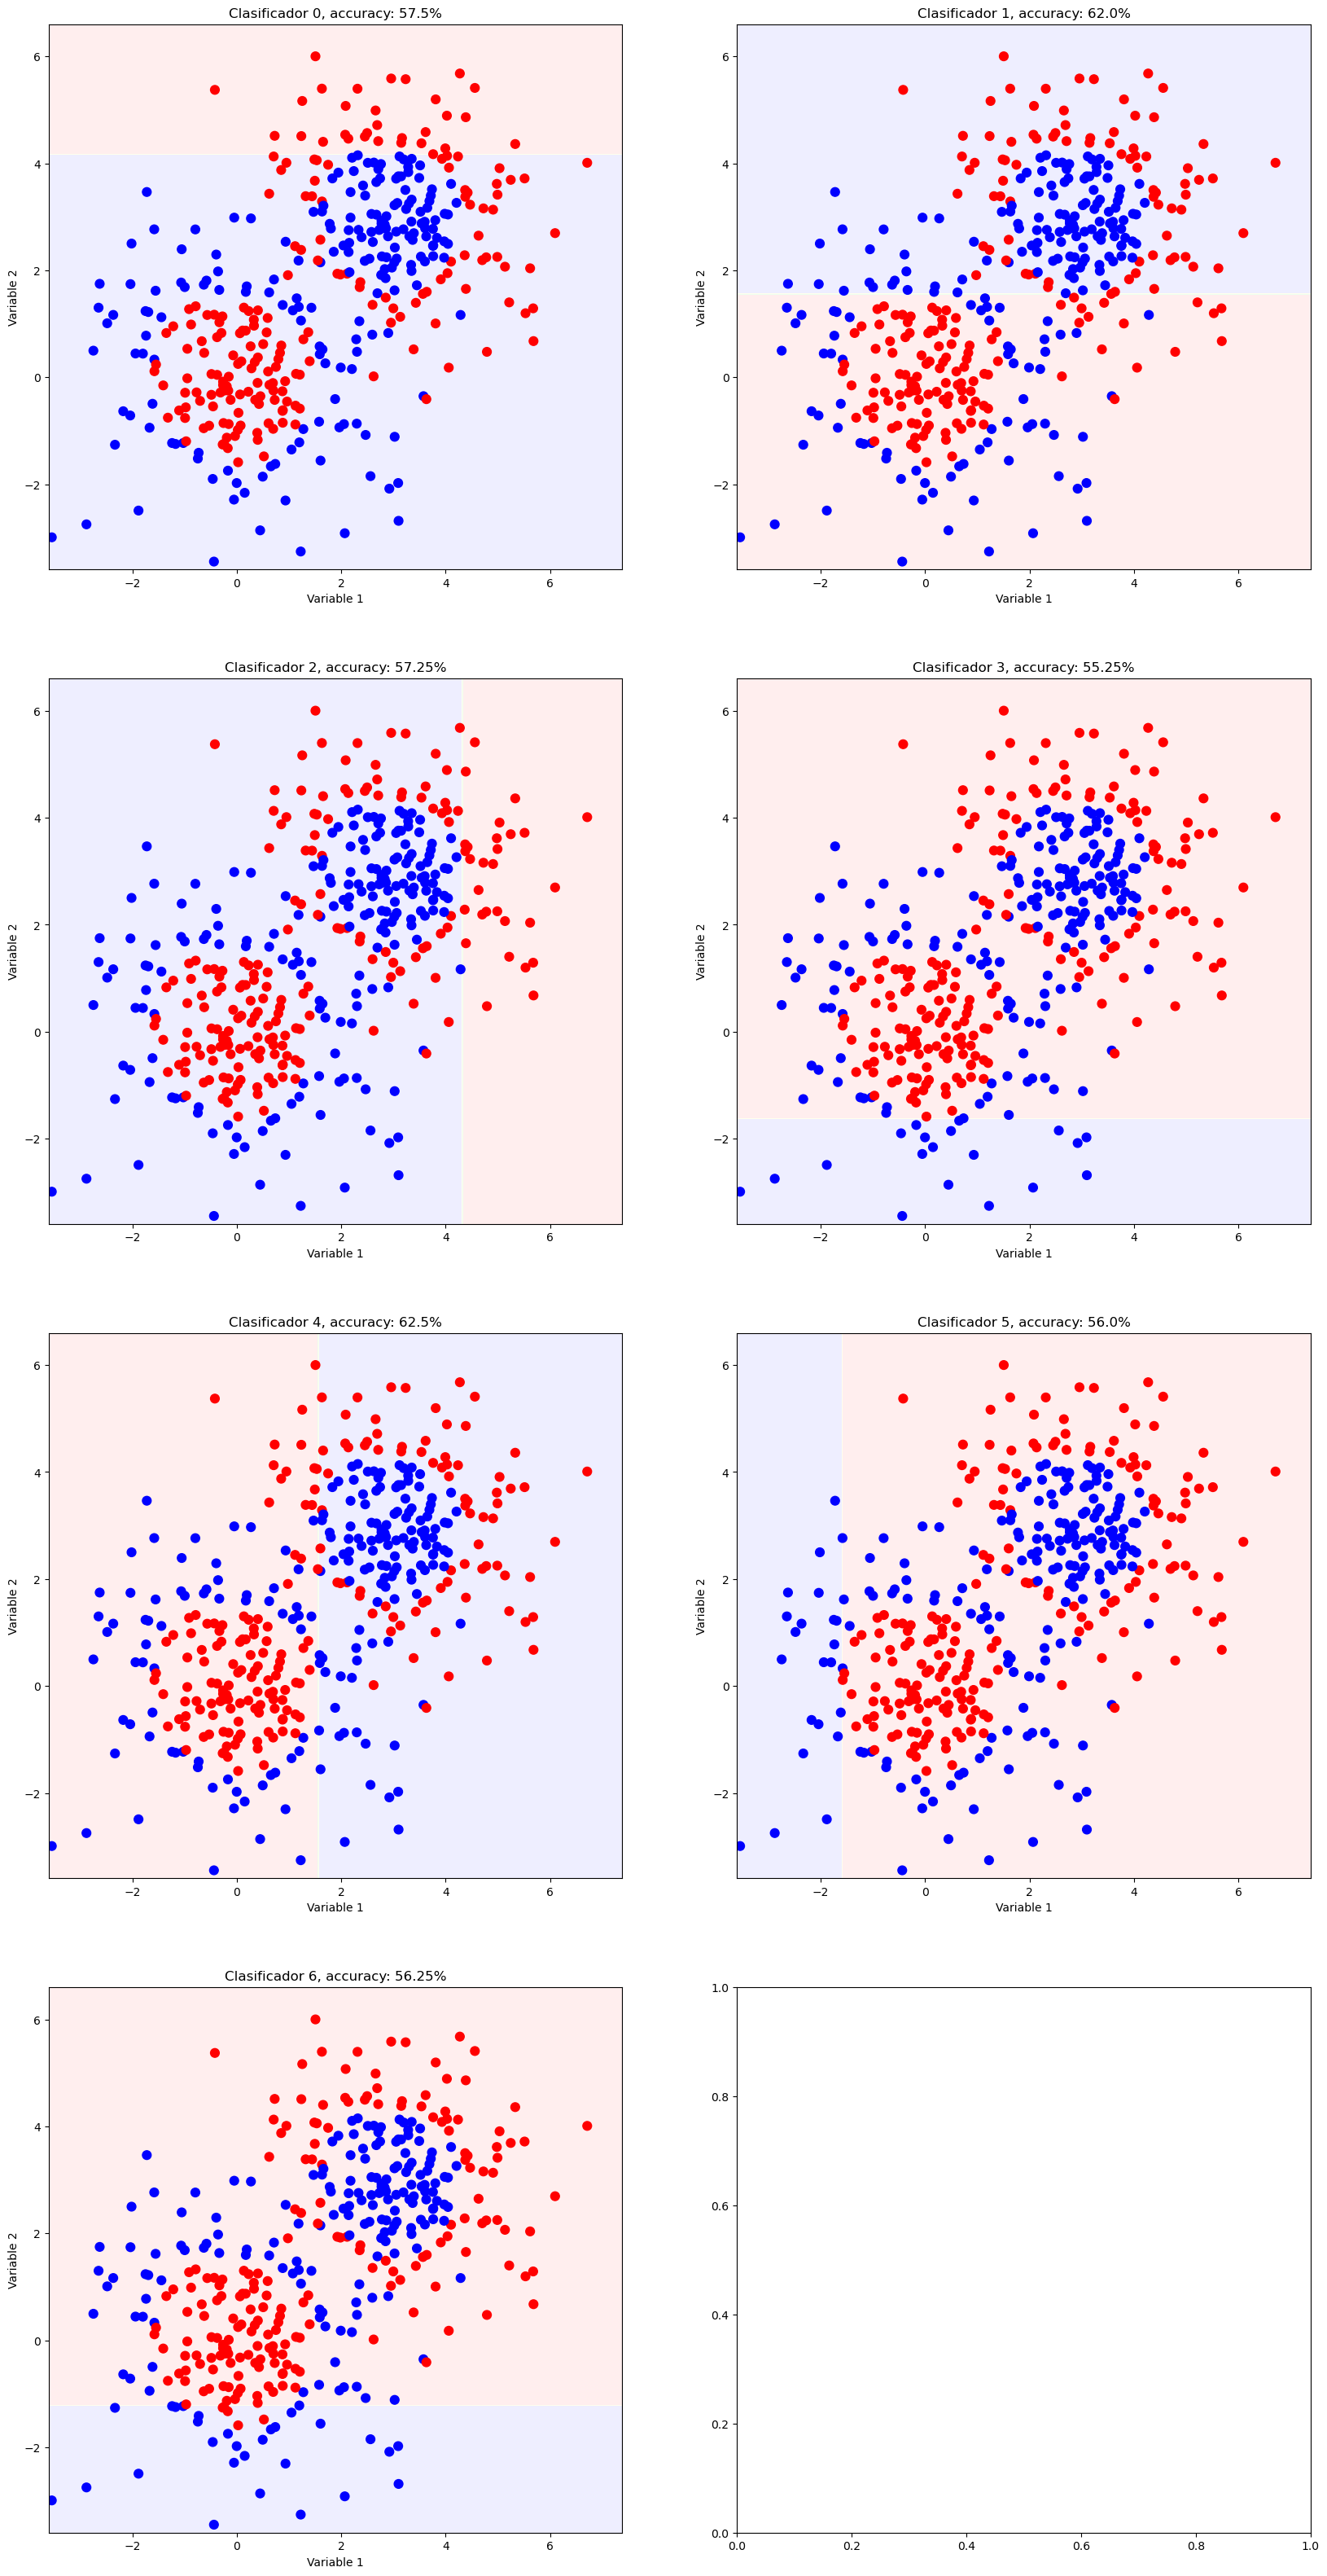

In [12]:
# Lista para almacenar el accuracy de cada clasificador base
lista_acc = []

# Definimos una figura para pintar todos los resultados
fig, ax = plt.subplots(np.ceil(len(adaboost.estimators_) / 2).astype('int'), 2, figsize=(20, 40)) 

# Por cada clasificador base
for i in range(len(adaboost.estimators_)):
    # Se calcula el porcentaje de acierto del clasificador base correspondiente: adaboost.estimators_[i]
    # Redondear a dos decimales
    acc = round(adaboost.estimators_[i].score(X,y)*100, 2)
    # Se añade a la lista de accuracies
    lista_acc.append(acc)
    # Establecemos el título de la figura con el número de clasificador y su precisión en train
    titulo = 'Clasificador {}, accuracy: {}%'.format(i, acc)
    # Mostramos la figura con los datos de train y la frontera del clasificador correspondiente
    # Recuerda pintarla en el eje ax.ravel()[i]
    mostrar(X, y, clasificador=adaboost.estimators_[i],title=titulo,ax=ax.ravel()[i])
print(lista_acc)

In [13]:
# Se realiza la corrección de los resultados
if (len(adaboost.estimators_)==5):
    test_nb(lista_acc, [57.5, 62.0, 57.25, 55.25, 62.5], 'Accuracy incorrecto para los clasificadores base del ensemble de 5 clasificadores')
else:
    test_nb(lista_acc, [57.5, 62.0, 57.25, 55.25, 62.5, 56.0, 56.25], 'Accuracy incorrecto para los clasificadores base del ensemble de 7 clasificadores')

✔️ Test passed.


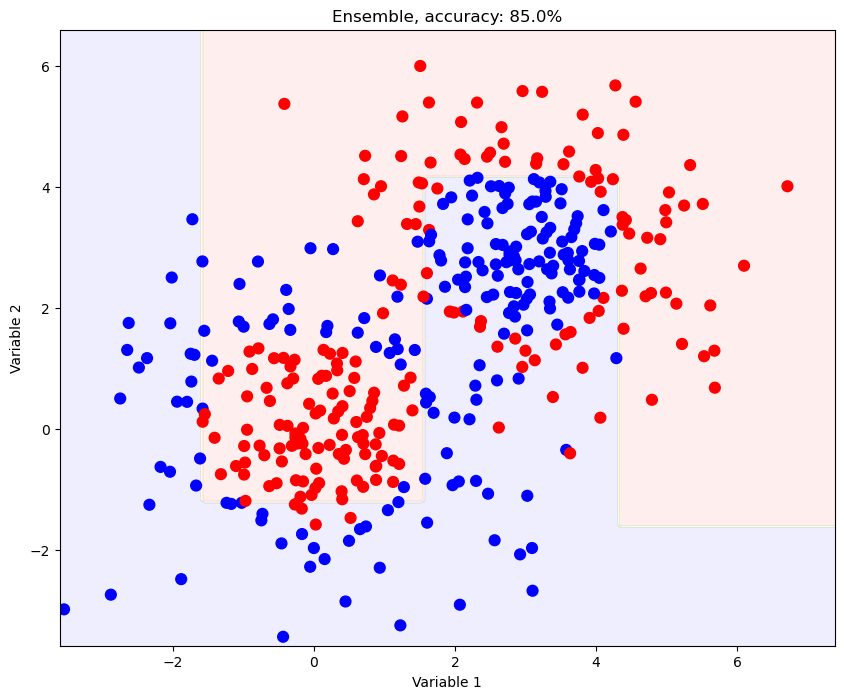

In [14]:
# Se calcula el porcentaje de acierto de AdaBoost
acc = round(adaboost.score(X,y)*100, 2)
# Establecemos el título de la figura
titulo = 'Ensemble, accuracy: {}%'.format(acc)
# Mostramos las figura
mostrar(X,y, clasificador=adaboost,title=titulo)

In [15]:
if (len(adaboost.estimators_) == 5):
    test_nb(acc, 82.25, 'Accuracy incorrecto para el ensemble de 5 clasificadores')
else:
    test_nb(acc, 85.00, 'Accuracy incorrecto para el ensemble de 7 clasificadores')

✔️ Test passed.


Realmente el clasificador Adaboost ha funcionado bien, y ha mejorado mucho el alto bias de los Decision Stump. Sim embargo la clasificación puede mejorarse. 

Comprueba cuántos clasificadores necesitas para alcanzar al menos un 87% de precisión en el conjunto de train (haz pruebas con diferentes números de clasificadores y comprueba el resultado gráficamente). No es necesario que muestres cada clasificador del ensemble, solo la figura del ensemble completo (la última del ejercicio anterior).

Accuracy in Train: 88.75


/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


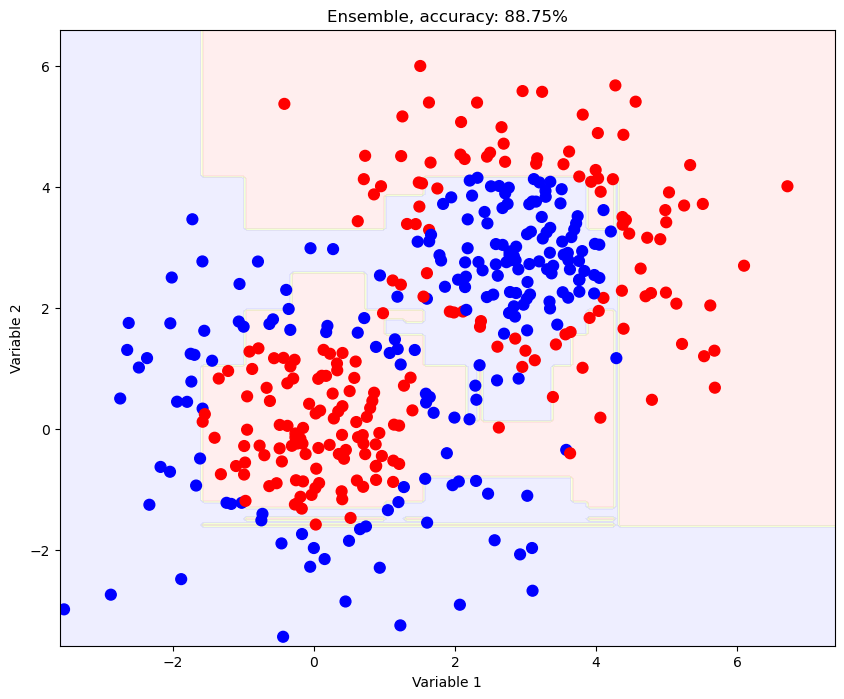

In [23]:
# Se define el número de clasificadores base de AdaBoost
num_clasificadores_base = 40
# Llamada al constructor del clasificador AdaBoost
adaboost = AdaBoostClassifier(estimator=tree,n_estimators=num_clasificadores_base,random_state=12)
# Entrenamiento del clasificador creado
adaboost.fit(X,y)
# Se calcula el porcentaje de acierto de AdaBoost
acc = round(adaboost.score(X,y)*100, 2)
# Establecemos el título de la figura
titulo = 'Ensemble, accuracy: {}%'.format(acc)
# Mostramos las figura
mostrar(X,y,clasificador=adaboost, title=titulo)

print("Accuracy in Train: {}".format(acc))

In [24]:
test_nb(acc >= 87.00, True, 'Accuracy no alcanzado')

✔️ Test passed.


## Visualizando Bagging con decision stumps

¿Qué crees que pasará si tratamos de afrontar el problema anterior con Bagging y Decision Stumps? Vamos a comprobarlo. Utiliza cinco clasificadores y el modelo BaggingClassifier con los mismos Decision Stumps de antes (`DecisionTreeClassifier` con `max_depth=1`).

Scikit-learn ofrece una clase correspondiente a Bagging que se encuentra dentro de la librería ensemble. Dicha clase se llama `BaggingClassifier` y toda su información se puede encontrar en el siguiente [enlace](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier).

La llamada al constructor y sus principales parámetros de entrada son los siguientes:

    BaggingClassifier(clasificador_base, n_estimators=numero_clasificadores_base, random_state=semilla)

Los parámetros de entrada son:
* `clasificador_base`: objeto de una clase correspondiente a un clasificador. Por defecto se utilizan los árboles de decisión: DecisionTreeClassifier. 
* `numero_clasificadores_base`: valor entero que determina el número de clasificadores que compondrán el ensemble. Por defecto es 10.
* `semilla`: valor que determina la semilla para la generación de números aleatorios.

Utiliza como semilla el 12.

In [33]:
# Importa la clase necesaria para usar Bagging
from sklearn.ensemble import BaggingClassifier
# Se define el número de clasificadores base de baggin. Utiliza 5 clasificadores base.
num_clasificadores_base,seed = 5,12
# Llamada al constructor del clasificador Baggin
bagging = BaggingClassifier(tree, n_estimators = num_clasificadores_base, random_state=seed)
# Entrenamiento del clasificador creado
bagging.fit(X,y)


BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=1),
                  n_estimators=5, random_state=12)

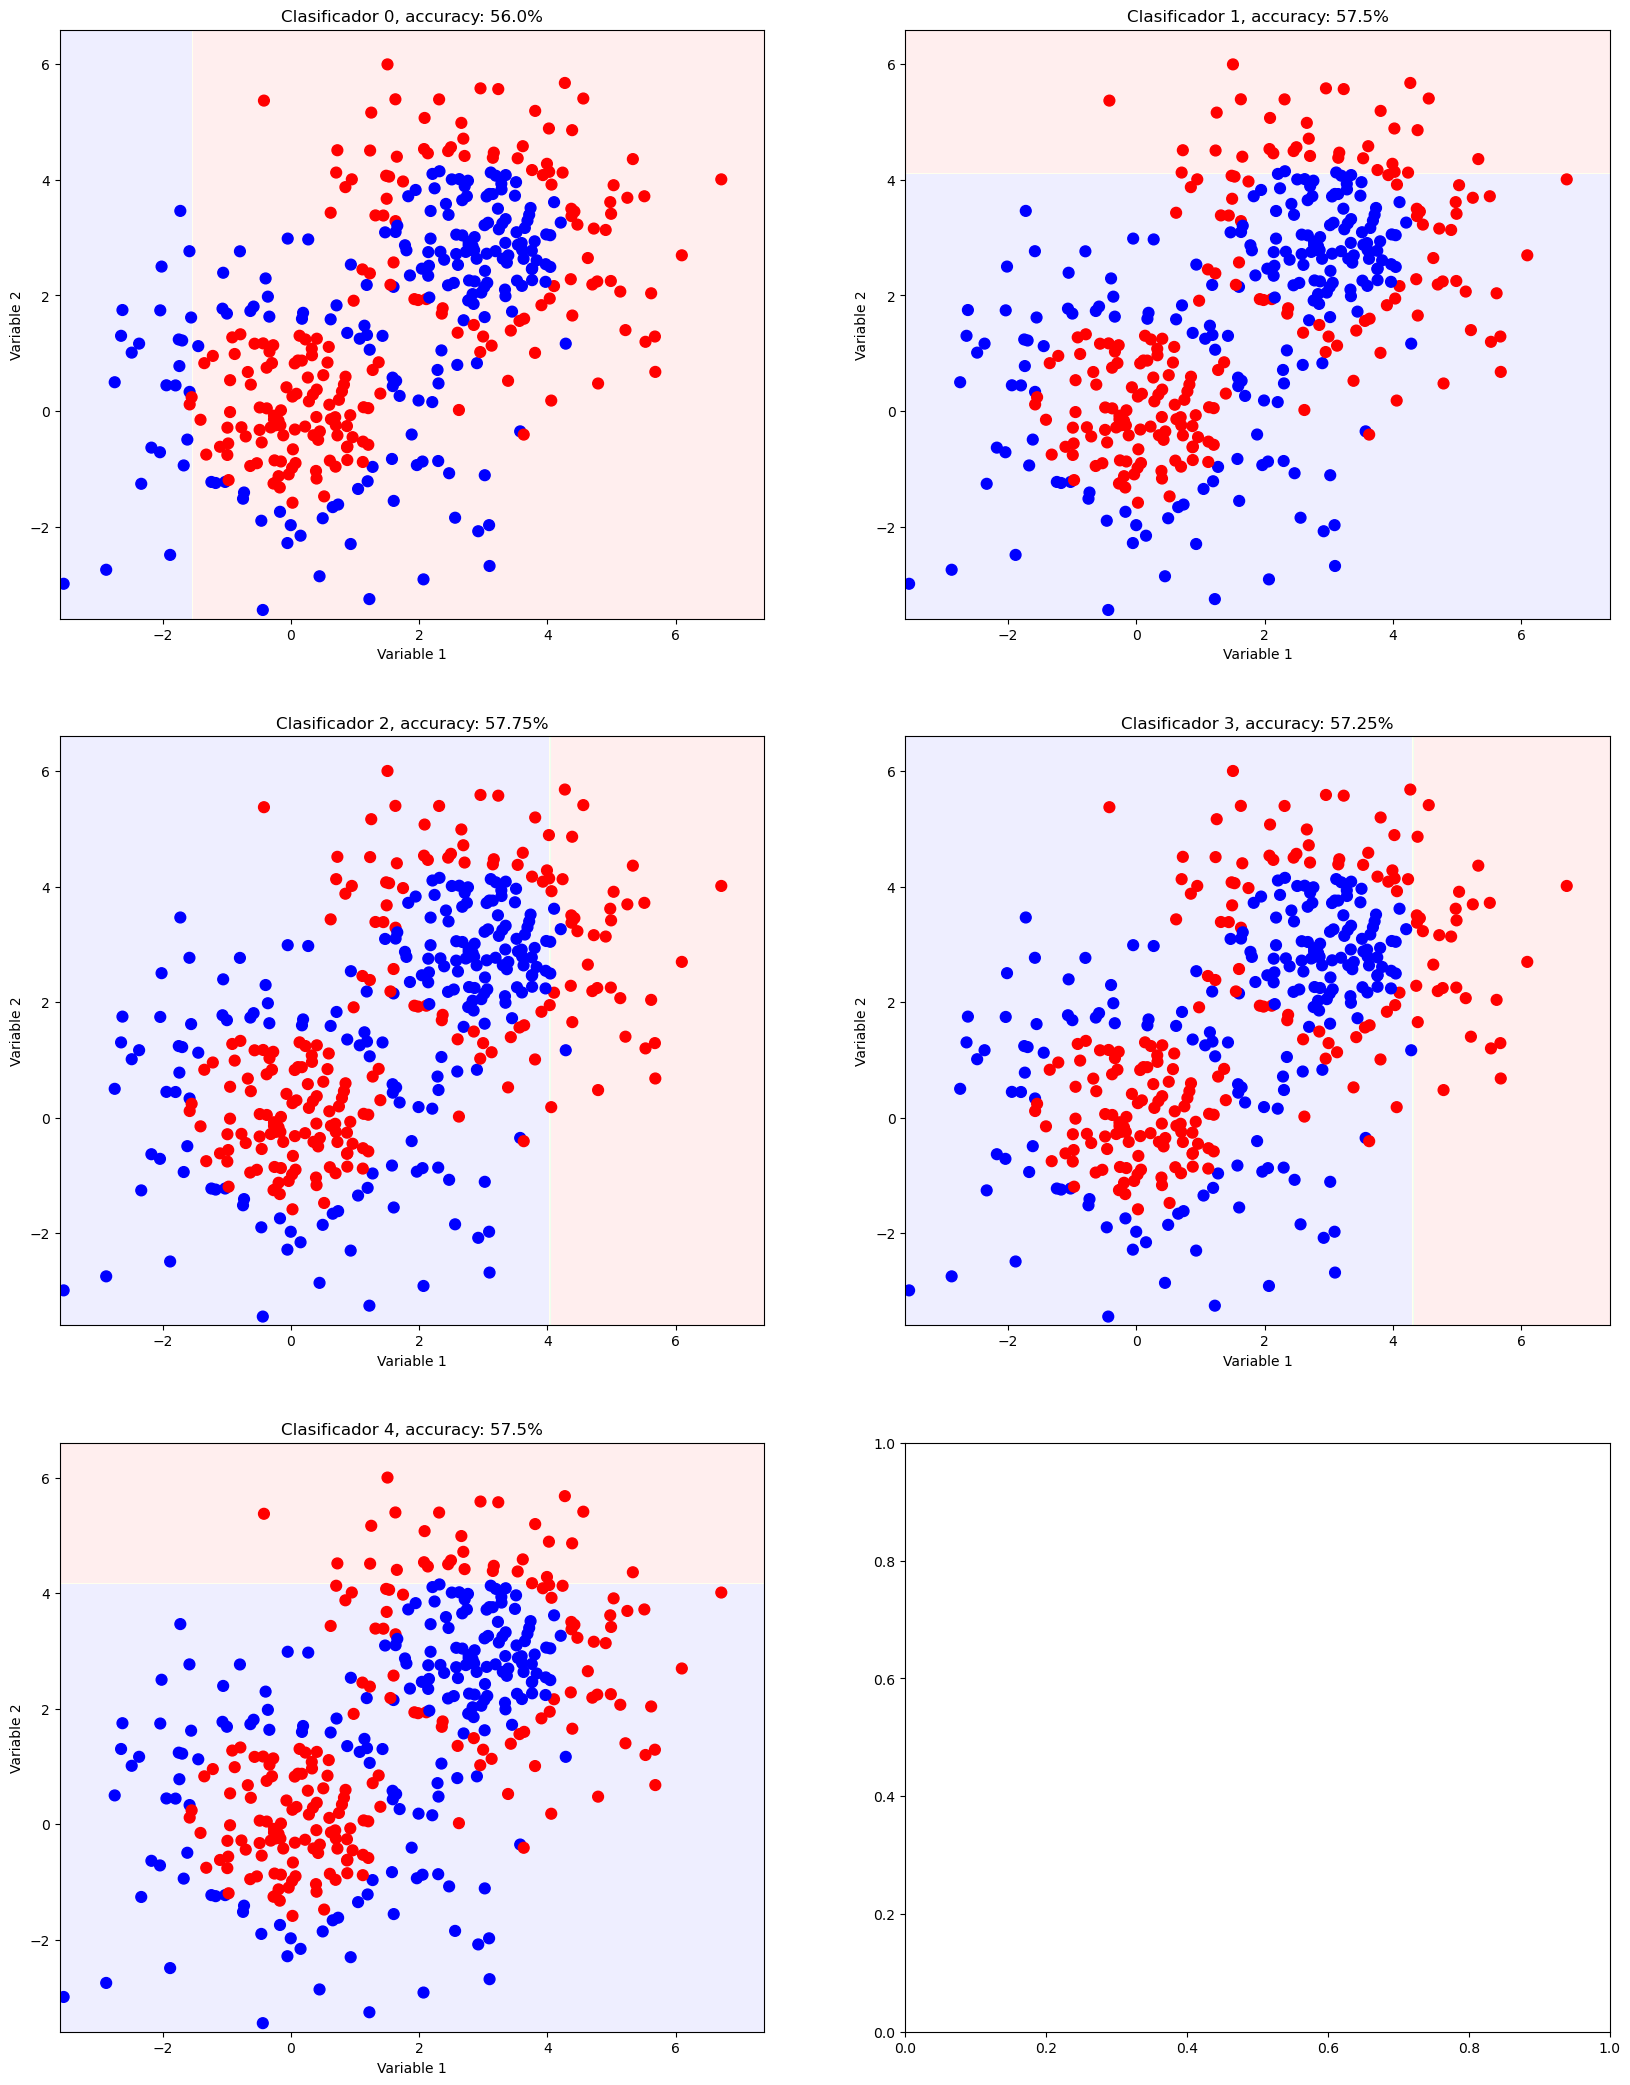

In [34]:
# Lista para almacenar el accuracy de cada clasificador base
lista_acc = []

# Definimos una figura para pintar todos los resultados
fig, ax = plt.subplots(np.ceil(len(bagging.estimators_) / 2).astype('int'), 2, figsize=(20, 26)) 

# Por cada clasificador base
for i in range(len(bagging.estimators_)):
    # Se calcula el porcentaje de acierto del clasificador base correspondiente: adaboost.estimators_[i]
    # Redondear a dos decimales
    acc = round(bagging.estimators_[i].score(X,y)*100,2)
    # Se añade a la lista de accuracies
    lista_acc.append(acc)
    # Establecemos el título de la figura con el número de clasificador y su precisión en train
    titulo = 'Clasificador {}, accuracy: {}%'.format(i, acc)
    # Mostramos la figura con los datos de train y la frontera del clasificador correspondiente (bagging.estimators_[i])
    # Recuerda pintarla en el eje ax.ravel()[i]
    
    mostrar(X,y,clasificador=bagging.estimators_[i],title=titulo, ax=ax.ravel()[i])

In [35]:
test_nb(lista_acc, [56.0, 57.5, 57.75, 57.25, 57.5], 'Precisiones incorrectas')

✔️ Test passed.


Accuracy in Train: 64.25


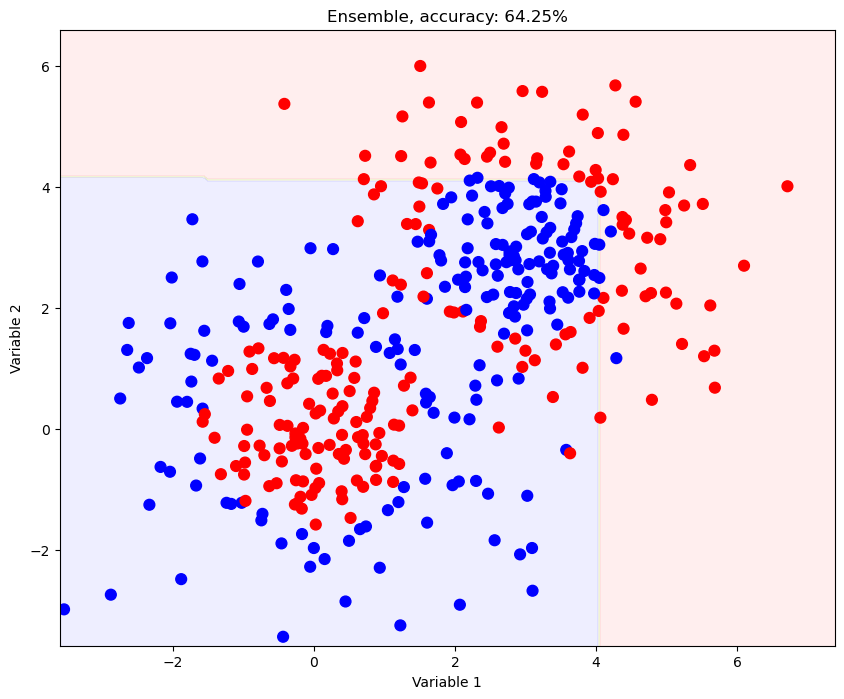

In [36]:
# Se calcula el porcentaje de acierto de Bagging
acc = round(bagging.score(X,y)*100,2)
# Establecemos el título de la figura
titulo = 'Ensemble, accuracy: {}%'.format(acc)
# Mostramos las figura
mostrar(X,y,clasificador=bagging, title=titulo)


print("Accuracy in Train: {}".format(acc))


In [29]:
test_nb(acc, 64.25, 'Accuracy incorrecto para el ensemble de 7 clasificadores')

✔️ Test passed.


¿Por qué crees que ocurre esto? ¿Se solucionaría el problema aumentando el número de clasificadores? Escribe tu respuesta en la siguiente celda.

ESCRIBE TU RESPUESTA

## Visualizando OVA y OVO

A continuación vamos a analizar el comportamiento de las técnicas de descomposición One-Versus-All (OVA) y One-Versus-One (OVO). 

La librería scikit-learn (sklearn) nos ofrece una clase para utilizar cada técnica de descomposición. La clase correspondiente a la técnica OVA se llama `OneVsRestClassifier` y está dentro de la librería multiclass. Toda la información de esta clase se puede encontrar en el siguiente [enlace](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier). Para utilizar dicha clase lo primero que tenemos que hacer es importarla

    from sklearn.multiclass import OneVsRestClassifier
    
La llamada al constructor es la siguiente:

    OneVsRestClassifier(estimator=clasificador_base)

El parámetro de entrada es:
* `clasificador_base`: objeto de una clase correspondiente a un clasificador. 

La clase correspondiente a la técnica OVO se llama `OneVsOneClassifier` y también está dentro de la librería multiclass. Toda la información de esta clase se puede encontrar en el siguiente [enlace](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html#sklearn.multiclass.OneVsOneClassifier). Para utilizar dicha clase lo primero que tenemos que hacer es importarla

    from sklearn.multiclass import OneVsOneClassifier
    
La llamada al constructor es la siguiente:

    OneVsOneClassifier(estimator=clasificador_base)

El parámetro de entrada es:
* `clasificador_base`: objeto de una clase correspondiente a un clasificador. 



Para mostrar el comportamiento de ambas técnicas de descomposición vamos a crear otro dataset sintético. Para ello vamos a utilizar la función `make_classification` de la librería datasets. Toda la información de esta función está en este [enlace](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Para poder utilizarla, en primer lugar debemos importarla.

    from sklearn.datasets import make_classification

Esta función permite crear conjuntos de ejemplos sintéticos y permite establecer el número de variables de entrada, de clases y de ejemplos a crear. La llamada a la función y sus principales parámetros de entrada y salida son los siguientes:

    X, y = make_classification(n_samples=numero_ejemplos, n_features=numero_variables, n_informative=numero_var_informativas, n_redundant=numero_var_redundantes, n_clusters_per_class=cluster_por_clase, n_classes=numero_clases, random_state=semilla)
    
Los parámetros de entrada son:
* `numero_ejemplos`: valor entero que determina el número de ejemplos a generar. Por defecto es 100.
* `numero_variables`: valor entero que determina el número de variables a generar. Por defecto es 20.
* `numero_var_informativas`: número de variables informativas. Por defecto es 2.
* `numero_var_redundantes`: número de variables redundantes. Por defecto es 2.
* `cluster_por_clase`: número de clústeres por cada clase. Por defecto es 2.
* `numero_clases`: valor entero que determina el número de clases a generar. Por defecto es 2.
* `semilla`: valor que determina la semilla para la generación de números aleatorios.

Los parámetros de salida son:
* `X`: los valores de  variables de entrada de los ejemplos generados.
* `y`: las clases de los ejemplos generados.

Vamos a generar un dataset con los siguientes valores de los parámetros:
* 300 ejemplos
* 2 variables
* 2 variables informativas
* 0 variables redundantes (es decir, ambas van a contener información relevante)
* 1 clúster por cada clase (es decir, todos los ejemplos de cada clase van a estar juntos)
* 4 clases
* semilla: valor 12

In [37]:
# Importamos la clase para generar los ejemplos sintéticos
from sklearn.datasets import make_classification

# Definimos el número de clases del problema (num_clases)
num_clases = 4

# Generamos las ejemplos sintéticos con los parámetros apropiados
X, y = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=num_clases, random_state=12)

In [38]:
# Se realiza la comprabación de la corrección en la generación de las clases
comprobacion_clases = (np.concatenate((y[:5],y[-5:]))==[2, 3, 3, 2, 2, 0, 2, 3, 0, 2]).all()
test_nb(comprobacion_clases, True, 'Valores de las clases incorrectos')

✔️ Test passed.


A continuación vamos a mostrar los ejemplos generados en una gráfica de dispersión de ejemplos (scatter).

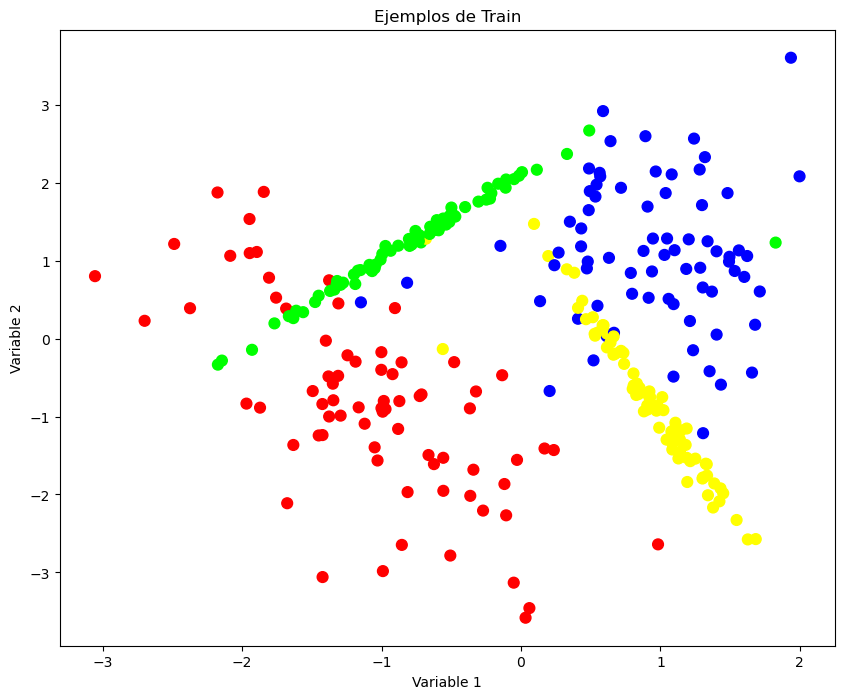

In [56]:
mostrar(X,y)


Una vez generado el dataset, vamos a crear y entrenar el ensemble de clasificadores con la **técnica de descomposición OVA**. Para ello, vamos a utilizar un clasificador con el que no hemos trabajado hasta ahora. Las máquinas de soporte vectorial o [Support Vector Machines (SVMs)](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte). Estos son unos clasificadores lineales muy potentes que a través de unas funciones denominadas kernels, permiten obtener fronteras de decisión no lineales. En este caso, utilizaremos el clasificador SVM con kernel Gaussiano que está disponible a través de la clase [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  en el paquete [sklearn.svm](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm) de scikit-learn.

In [57]:
# Se importan las clase para OVA y para SVM
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Se llama al constructor de OVA utilizando SVM como clasificador base
svm = SVC()
OVA = OneVsRestClassifier(estimator=svm)
# Se entrena el modelo OVA
OVA.fit(X,y)

OneVsRestClassifier(estimator=SVC())

Una vez entrenado (generado) el modelo OVA vamos a mostrar gráficamente el comportamiento del mismo. Para ello, vamos a crear tantas gráficas como clasificadores clases para mostrar la superficie de decisión de cada clasificador base y otra más en la que mostraremos la superficie de decisión del ensemble realizado por OVA.

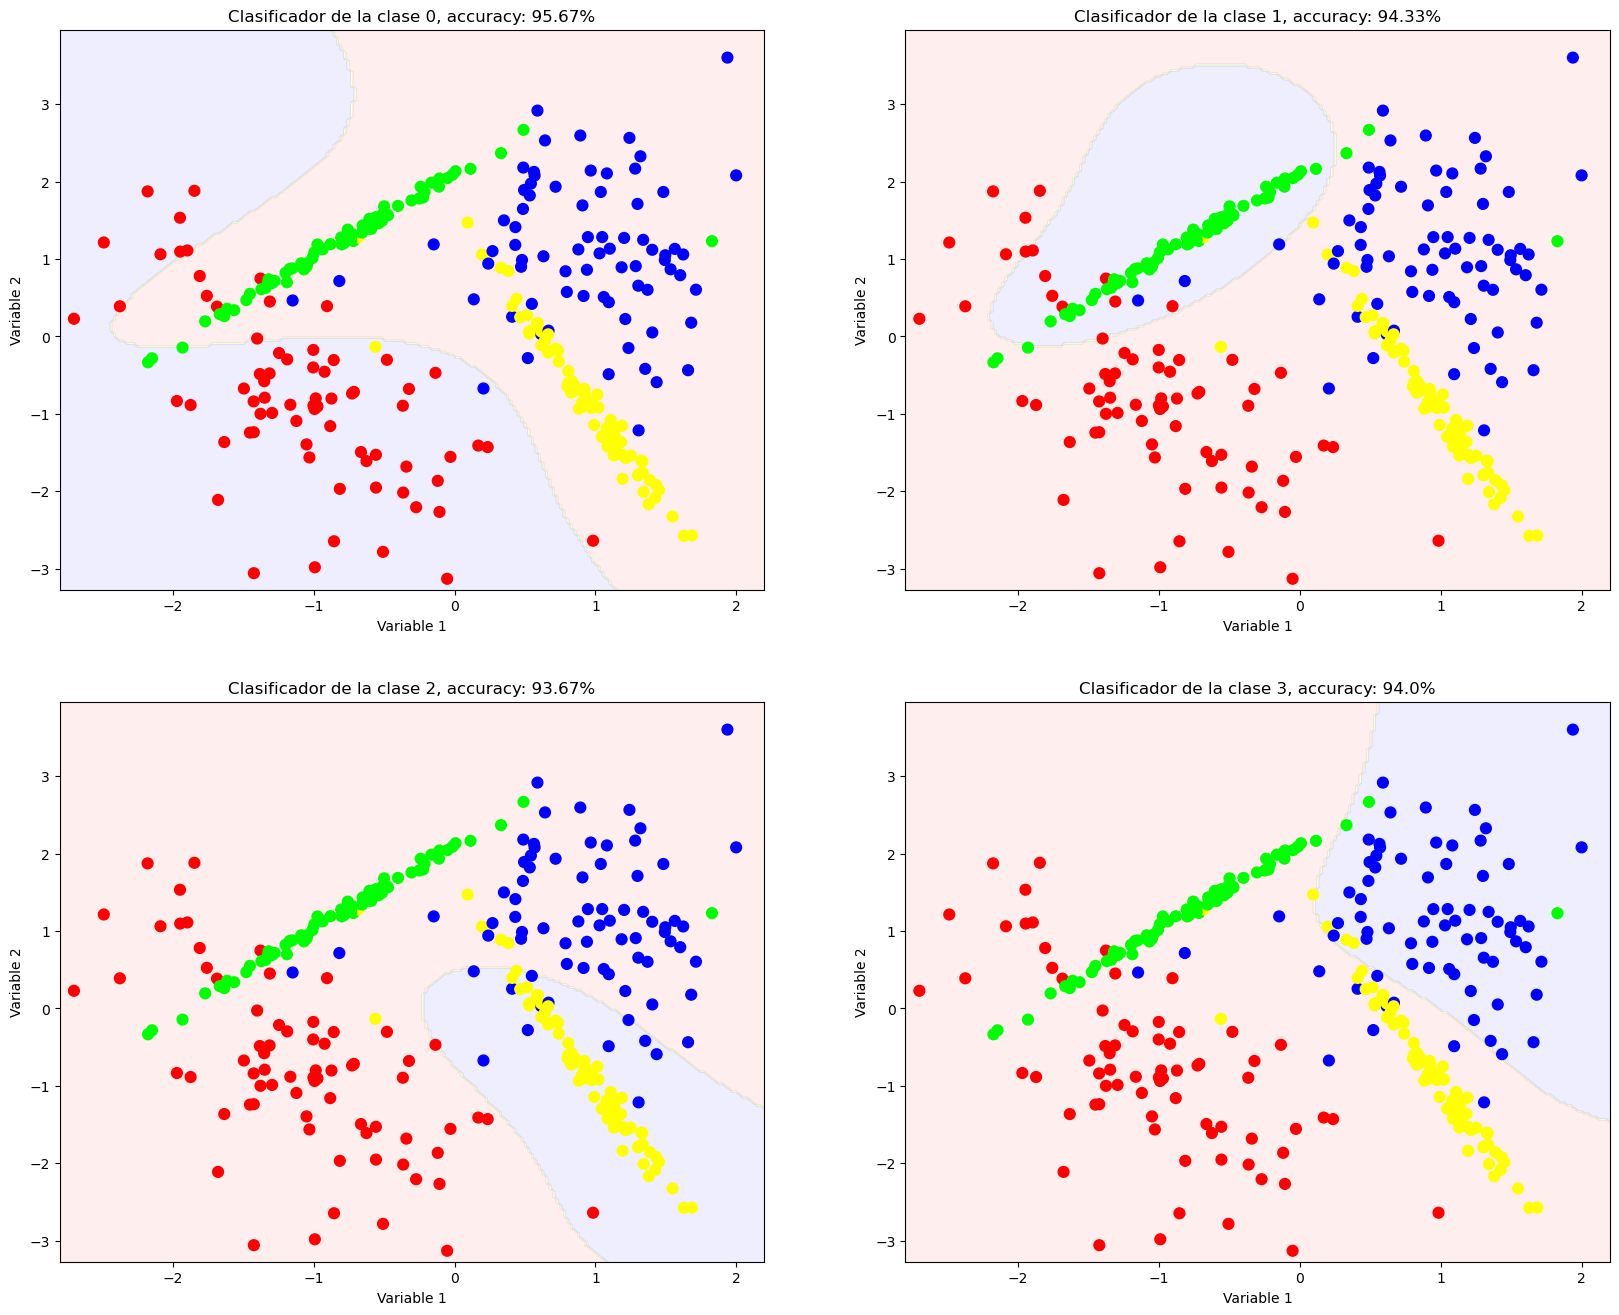

In [58]:
# Lista para las precisiones de cada clasificador
lista_acc = []

# Definimos una figura para pintar todos los resultados
fig, ax = plt.subplots(np.ceil(len(OVA.estimators_) / 2).astype('int'), 2, figsize=(20, 16)) 

# Por cada clasificador base
for i in range(len(OVA.estimators_)):
    # Crea un vector llamado y_ejemplos_clase_i del tamaño del número de ejemplos
    # que tenga un 1 en la posición de los ejemplos de la clase i y un 0 en el resto
    y_ejemplos_clase_i = np.where(y==i, 1,0)
    
    # Se calcula el porcentaje de acierto del clasificador base correspondiente: OVA.estimators_[i]
    # Redondear a dos decimales
    acc = round(OVA.estimators_[i].score(X, y_ejemplos_clase_i)*100, 2)
    # Se añade a la lista de accuracies
    lista_acc.append(acc)
    
    # Obtenemos el título de la figura con el número de clasificador base y su precisión
    titulo = 'Clasificador de la clase {}, accuracy: {}%'.format(i, acc)
    # Mostramos la figura
    # Recuerda pintarla en el eje ax.ravel()[i]
    mostrar(X, y, OVA.estimators_[i], titulo, ax.ravel()[i])

In [59]:
test_nb(lista_acc, [95.67, 94.33, 93.67, 94.0], 'lista_acc incorrecta')

✔️ Test passed.


Precisión en Train: 88.33


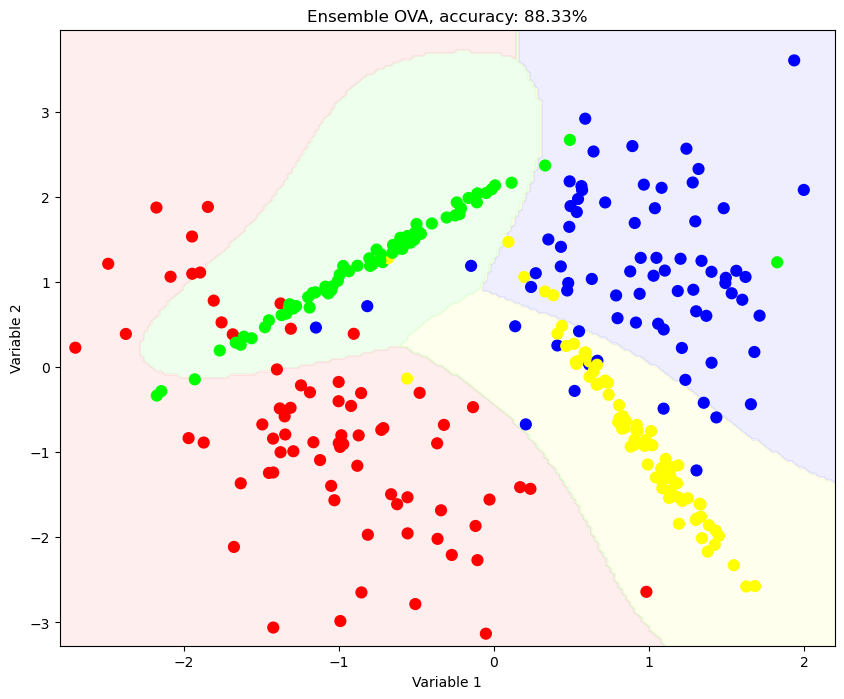

In [61]:
# Se calcula el porcentaje de acierto de OVA
acc = round(OVA.score(X, y)*100,2)
# Establecemos el título y mostramos la figura
titulo = 'Ensemble OVA, accuracy: {}%'.format(acc)
mostrar(X,y,clasificador=OVA,title=titulo)
print("Precisión en Train: {}".format(acc))

In [62]:
# Se realiza la corrección de los resultados
test_nb(acc, 88.33, 'Accuracy incorrecto para OVA')

✔️ Test passed.


A continuación vamos a aplicar la **técnica de descomposición OVO**. Para ello vamos a crear y entrenar el ensemble de clasificadores utilizando de nuevo como clasificador base el algoritmo SVM (utilizar la configuración por defecto en la llamada al constructor de dicho clasificador).

In [63]:
# Se importan las clase para OVO
from sklearn.multiclass import OneVsOneClassifier
# Se llama al constructor de OVO utilizando SVM como clasificador base
OVO = OneVsOneClassifier(estimator=svm)
# Se entrena el modelo OVO
OVO.fit(X,y)


OneVsOneClassifier(estimator=SVC())

Una vez entrenado (generado) el modelo OVO vamos a mostrar gráficamente el comportamiento del mismo. Para ello, vamos a crear tantas gráficas como pares de clases para mostrar la superficie de decisión de cada clasificador base y otra más en la que mostraremos la superficie de decisión del ensemble realizado por OVO.

En primer lugar vamos a generar una lista en las que vamos a reflejar el orden en el que se aprenden las clases para cada uno de los clasificadores base. Es decir, primero se aprende el clasificador que distingue las clases `0` y `1`, luego el de las clases `0` y `2` (así hasta aprender el clasificador que diferencia las clases `0` y `num_clases-1`). Después se aprenden los clasificadores que diferencian las clases `1` y `2`, la `1` y `3` y así hasta la `1` contra la `num_clases-1`. Este proceso se repete hasta el clasificador que diferencia las clases `num_clases-2` y `num_clases-1`. 

Ejemplos de clasificares para 4 clases: 0-1,0-2,0-3,1-2,1-3,2-3. Por tanto, las listas a generar serán dos:
* lista: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

Posteriormente, utilizaremos estas dos listas para seleccionar los ejemplos correspondientes a cada clasificador base y por tanto mostrarlos en la gráfica correspondiente a la superficie de decisión generada para cada par de clases.

In [64]:
clases = []
for i in range(num_clases - 1):
    for j in range(i+1, num_clases):
        # Añadir índices a la lista
        clases.append((i,j))

print(clases)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [65]:
test_nb(clases, [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)], 'Lista clases incorrecta')

✔️ Test passed.


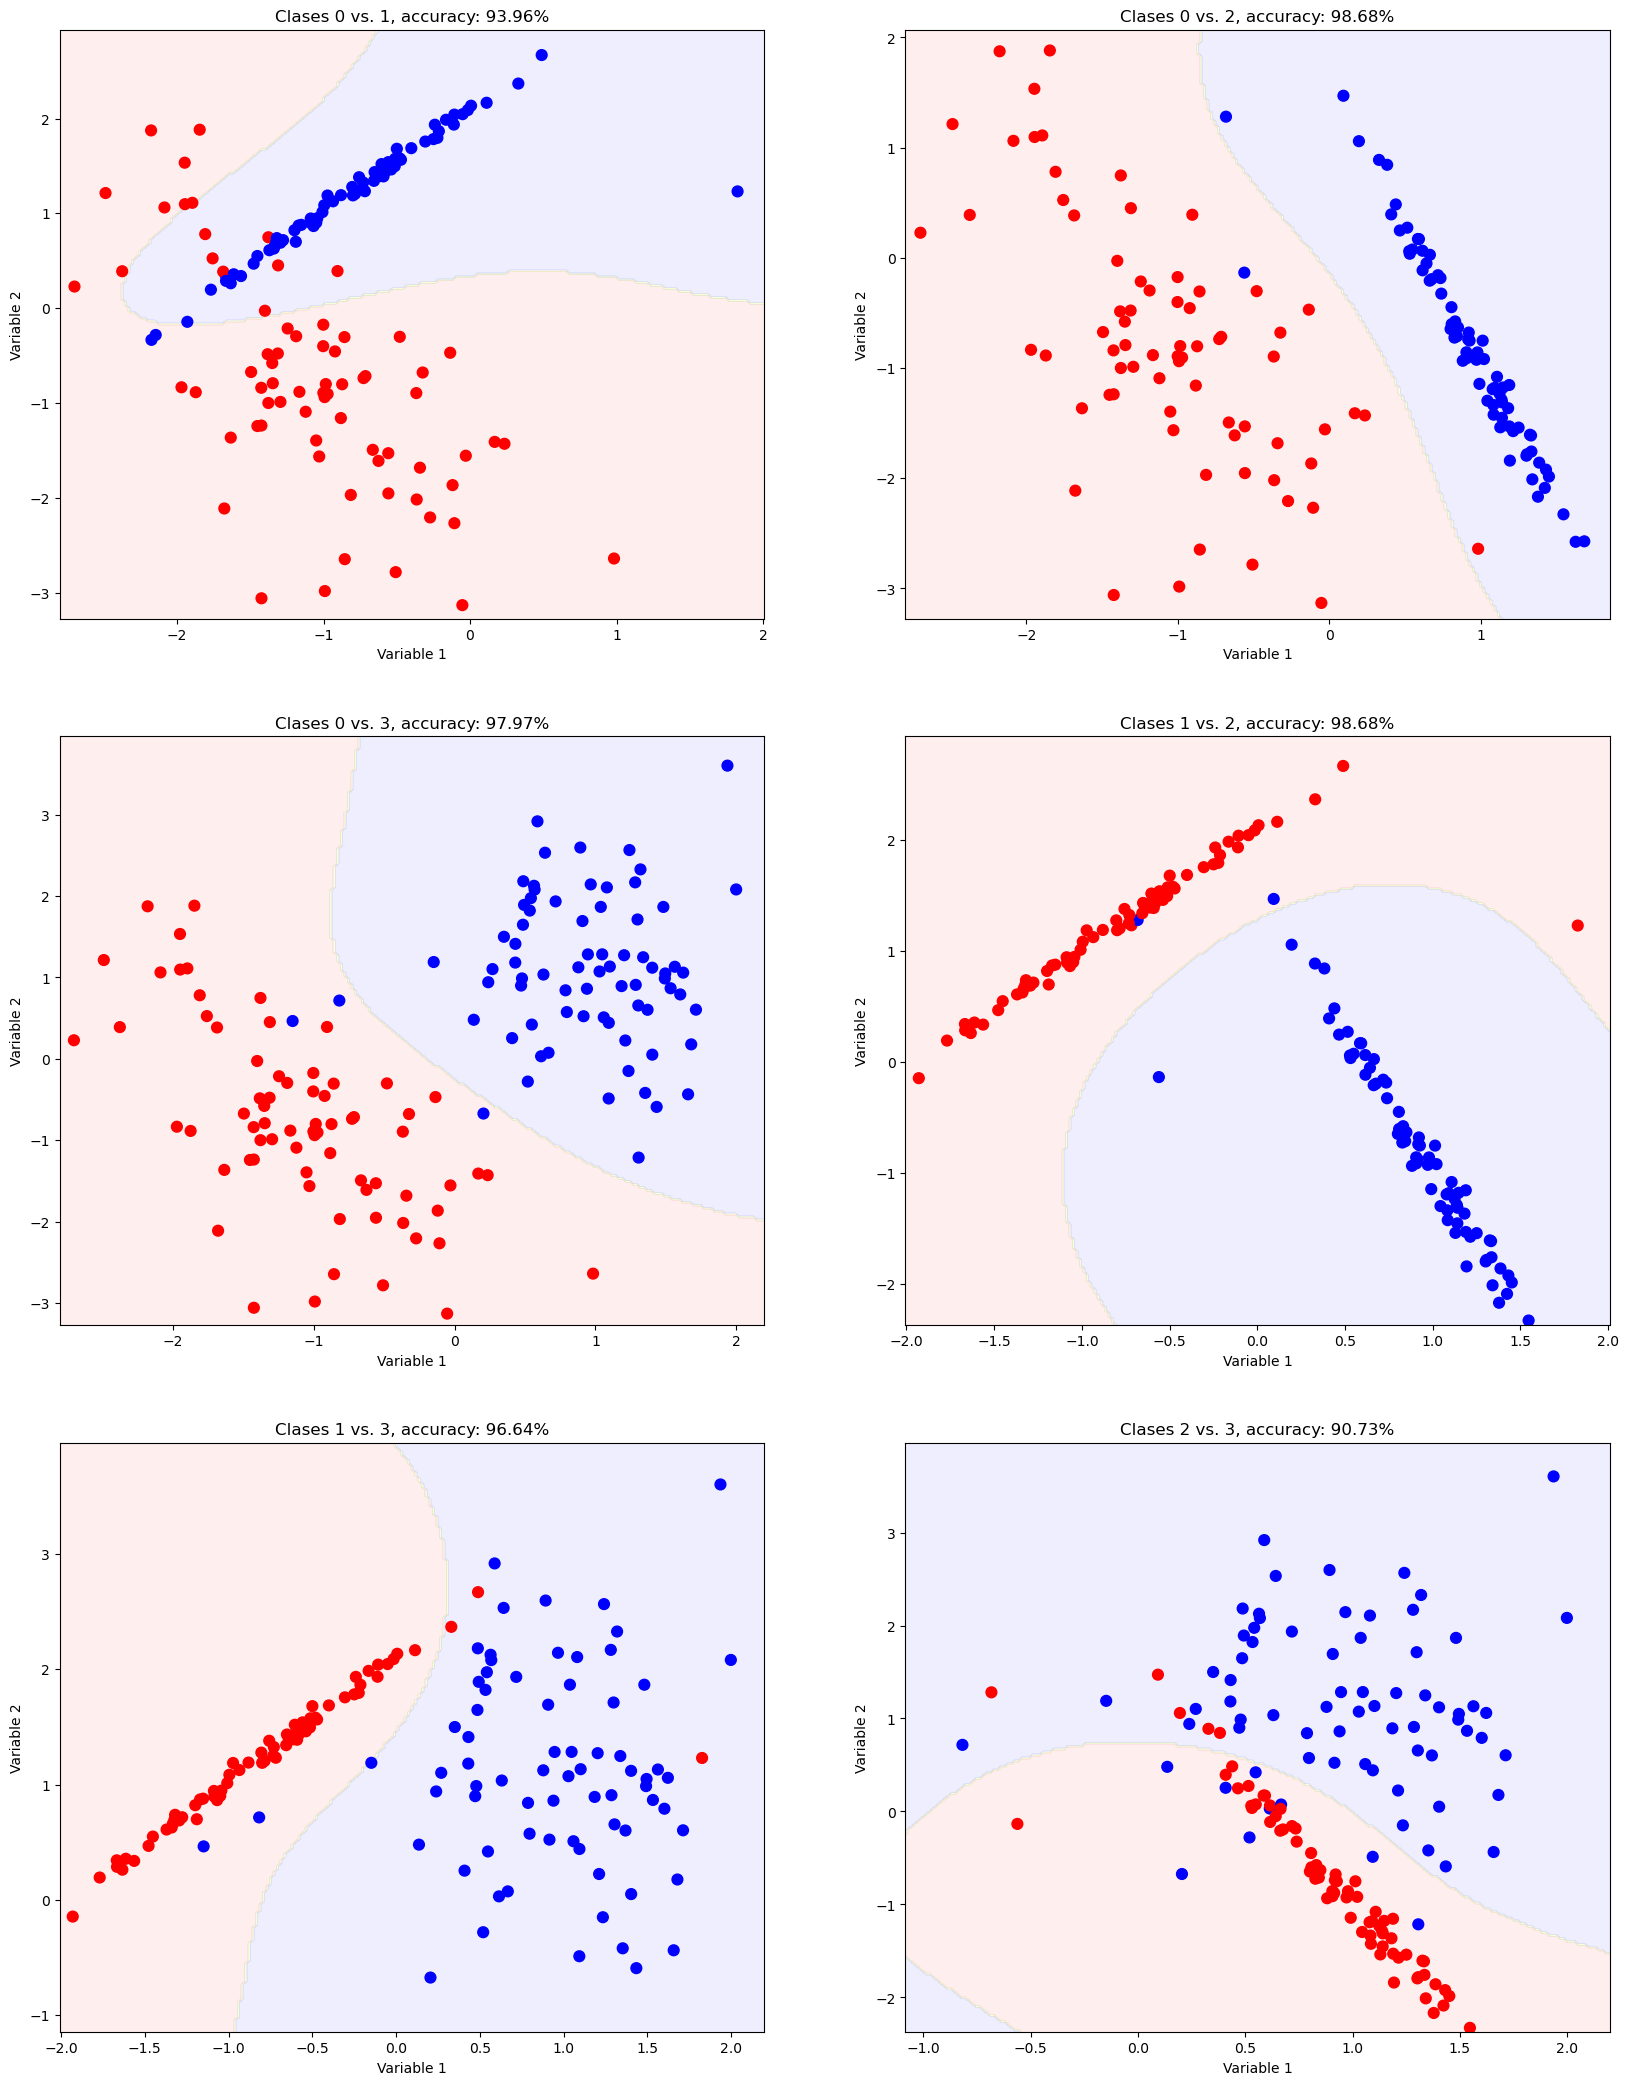

In [67]:
# Lista para las precisiones
lista_acc = []

# Definimos una figura para pintar todos los resultados
fig, ax = plt.subplots(np.ceil(len(OVO.estimators_) / 2).astype('int'), 2, figsize=(20, 26)) 

# Por cada clasificador base
for i in range(len(OVO.estimators_)):
    # La clase positiva es la del vector clases[i][1] y la negativa la de clases[i][0]
        
    # Obtén un vector que represente una máscara de 0s y 1s, donde los ejemplos
    # de las clases del utilizadas en el clasificador actual estén a 1 y el resto a 0
    # Puedes llamar a este vector ejemplos_clases_i_j
    ejemplos_clases_i_j = (y == clases[i][1]) | (y == clases[i][0])
    # Ahora, utiliza el vector anterior para quedarte con los ejemplos de dichas clases
    # Almacénalos en X_ejemplos_clases_i_j e y_ejemplos_clases_i_j
    X_ejemplos_clases_i_j = X[ejemplos_clases_i_j]
    y_ejemplos_clases_i_j = y[ejemplos_clases_i_j]
    # Por último, transforma tu vector y_ejemplos_clases_i_j en un vector que 
    # tenga unos en los ejemplos de la clase positiva (clases[i][1]) y 0 en las de la otra clase (clases[i][0])
    y_ejemplos_clases_i_j = (y_ejemplos_clases_i_j == clases[i][1])
    
    # Se calcula el porcentaje de acierto del clasificador base correspondiente: OVO.estimators_[i]
    # Solo sobre los ejemplos usados en entrenamiento (los que acabas de filtrar!)
    # Redondear a dos decimales
    acc = round(OVO.estimators_[i].score(X_ejemplos_clases_i_j, y_ejemplos_clases_i_j)*100, 2)
    # Se añade a la lista de accuracies
    lista_acc.append(acc)
    
    # Establecemos el título
    titulo = 'Clases {} vs. {}, accuracy: {}%'.format(clases[i][0], clases[i][1], acc)
    # Mostramos los ejemplos utilizados en el clasificador OVO. De la matriz X solo coger aquellos ejemplosSeleccionados
    # Recuerda pintarla en el eje ax.ravel()[i]
    mostrar(X_ejemplos_clases_i_j, y_ejemplos_clases_i_j, OVO.estimators_[i], titulo, ax.ravel()[i])

In [ ]:
test_nb(lista_acc, [93.96, 98.68, 97.97, 98.68, 96.64, 90.73], 'lista_acc incorrecta')

Precisión en Train: 90.0


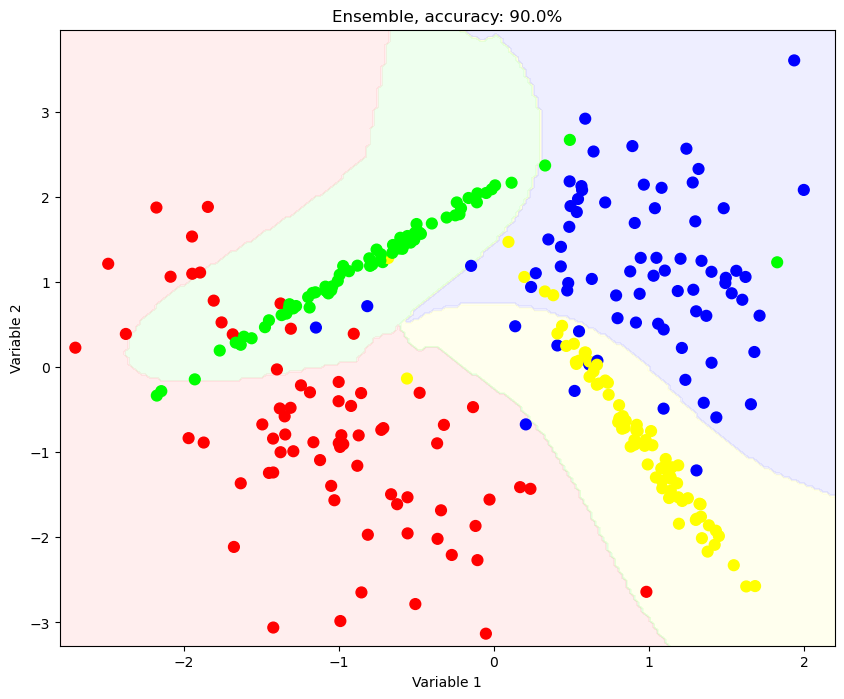

In [68]:
# Se calcula el porcentaje de acierto de OVO
acc = round(OVO.score(X,y)*100,2)

# Establecemos el título y mostramos la figura
titulo = 'Ensemble, accuracy: {}%'.format(acc)
mostrar(X,y,clasificador=OVO,title=titulo)
print("Precisión en Train: {}".format(acc))

In [69]:
# Se realiza la corrección de los resultados
test_nb(acc, 90.0, 'Accuracy incorrecto para OVO')

✔️ Test passed.


## Comparativa DecisionTree, Bagging, Boosting y Random Forest

Finalmente, vamos a probar el rendimiento de todos los tipos de ensembles explicados en teoría (Bagging, Boosting y Random Forest) sobre varios problemas de clasificación real. Los problemas con los que vamos a tratar son:

* **Banana** es un dataset artificial con dos clases y dos atributos reales. Tiene alrededor de 5000 instancias por lo que las ejecuciones serán algo más lentas con él. El dataset resulta interesante porque nos permita estudiar de manera simple y visual el comportamiento de los modelos de selección de instancias. [Más información](http://sci2s.ugr.es/keel/dataset.php?cod=182)

* **Iris** es un dataset de un problema de clasificación en el que se deben distinguir tres tipos de plantas iris según las cuatro características reales establecidas. Para poder trabajar visualmente con dicho dataset, en esta práctica utilizaremos una modificación del mismo en el que utilizaremos únicamente las dos últimas características. El dataset ya está transformado para tal fin. [Más información](http://archive.ics.uci.edu/ml/datasets/Iris)

* **Australian** consiste en decidir si se debe conceder a una persona dada una tarjeta de crédito o no. El conjunto de datos es interesante porque tiene características numéricas (8) y nominales o categóricas (6). [Más información](http://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29)

* **Crx** consiste en decidir si se debe conceder a una persona dada una tarjeta de crédito o no. El conjunto de datos es interesante porque tiene características numéricas (6) y nominales o categóricas (9). Es una versión extendida del conjunto de datos *Australian*. [Más información](http://archive.ics.uci.edu/ml/datasets/Credit+Approval)

* **Spambase** es un conjunto de datos correspondiente a la clasificación de emails en Spam o No Spam. Para ello cada e-mail viene representado por 57 características numéricas (en su mayoría frecuencias de aparición de palabras). [Más información](http://archive.ics.uci.edu/ml/datasets/Spambase)

Cada conjunto de datos está en formato KEEL. Para leer este tipo de formato os facilitamos un fichero python `dataset.py` que permite leer los ficheros mediante `ds.lectura_datos(ruta_fichero)`. Esta lectura nos devuelve una estructura de Python de la cual nos interesan los siguientes campos:
* `data`: Es la matriz que contiene los ejemplos (tantas filas como ejemplos y columnas como atributos).
* `target`: Es una array que contiene las clases de los ejemplos leídos (tantos elementos como ejemplos).

Los conjuntos de datos ya vienen particionados en train y test. Pero para seleccionar el mejor modelo para cada dataset vamos a particionar el conjunto de train en dos partes, train y validación (75% para train y 25% para validación). Para ello utilizaremos la función `train_test_split` de scikit-learn. Una vez hecho el particionamiento guardaremos un diccionario con los datasets `nombre dataset -> (X_train, X_val, X_test, y_train, y_val, y_test)` para luego simplemente acceder a un conjunto de datos haciendo por ejemplo para iris `X_train, X_val, X_test, y_train, y_val, y_test = datasets['iris']`.

No trabajaremos con OVO y OVA al ser datasets con solo dos clases.

Lo primero, crea una función que reciba dos conjuntos de datos leídos con `ds.lectura_datos` y devuelva una tupla con el nuevo particionamiento: `(X_train, X_val, X_test, y_train, y_val, y_test)`. Recuerda que los datos de test son los mismos que los leídos y que solo debes dividir el conjunto de train. Utiliza como semilla el `13` al aplicar `train_test_split`. 

In [70]:
from sklearn.model_selection import train_test_split

def particionar(datos_train, datos_test):
    # Establecemos X e y a partir de datos_train
    X, y = datos_train.data, datos_train.target
    
    # Establecemos X_test e y_test a partir de datos_test
    X_test, y_test = datos_test.data, datos_test.target

    # Utiliza train_test_split para dividir el conjunto de train inicial (X, y) en 75% para train y 25% para validación
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25, random_state=13)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

Los ensembles de Bagging y Boosting ya los hemos utilizado en la primera parte de la práctica. Como clasificador base utilizaremos la clase `DecisionTreeClassifier` de nuevo (como con `DecisionStump`), pero en este caso **sin limitar la profundidad** (`max_depth` lo dejaremos por defecto). Como **semilla utilizar siempre el valor 12**.


El tercer tipo de ensemble que vamos a probar es el realizado por la técnica **Random Forest**. Scikit-learn ofrece una clase correspondiente a este clasificador que se encuentra dentro de la librería ensemble. Dicha clase se llama `RandomForestClassifier` y toda su información se puede encontrar en el siguiente [enlace](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).
La llamada al constructor y sus principales parámetros de entrada son los siguientes:

    RandomForestClassifier(criterion=medida_impureza, max_features = numero_variables, n_estimators=numero_clasificadores_base, random_state=semilla)

Los parámetros de entrada son:
* `medida_impureza`: tipo de medida de impureza (`'gini'` o `'entropy'`). Por defecto es `'gini'`.
* `numero_variables`: número de variables a evaluar en cada nodo de cada árbol de decisión que forma en random forest.
* `numero_clasificadores_base`: valor entero que determina el número de clasificadores que compodrán el ensemble. Por defecto es 10.
* `semilla`: valor que determina la semilla para la generación de números aleatorios.

**Importante**

> Utiliza `'log2'` para obtener el número de variables a evaluar en cada nodo de los árboles de decisión y establece la medida de impureza a `'entropy'`. 

> En todos los casos aprendenderemos 15 clasificadores y debes establecer para cada dataset cuál es el mejor modelo y cuál es su capacidad de generalización (precisión en test).

A continuación tienes unos fragmentos de código de los que puedes hacer uso, aunque puedes hacerlo de la forma que te parezca más oportuna.

Debes utilizar una lista llamada `winners` para almacenar el mejor clasificador para cada problema y su precisión en test (en forma de tupla `(clasificador, precision_test)`).

In [71]:
# Establecemos los nombres de los datasets a utilizar
nombres_datasets = ['banana', 'iris', 'australian', 'crx', 'spambase']

# Inicializamos el diccionario
datasets = {}

# Para cada dataset realizamos las operaciones
for dataset in nombres_datasets:
    # Establecemos la ruta del train y el test
    file_train = 'datasets/' + dataset + '/' + dataset + '-5dobscv-2tra.dat'
    file_test = 'datasets/' + dataset + '/' + dataset + '-5dobscv-2tst.dat'
    # Leemos los datos con ds.lectura_datos 
    train, original_tr = ds.lectura_datos(file_train)
    test, original_test = ds.lectura_datos(file_test)
    # Finalmente almacenamos el dataset en formato de tupla (X_train, X_val, X_test, y_train, y_val, y_test) tras particionar 
    # con la función definida anteriormente
    # Almacenar la tupla resultado en datasets[dataset]
    datasets[dataset] = particionar(train, test)
    
    print("Ejemplos por clase en " + dataset + ":")
    print(np.bincount(train.target))

Ejemplos por clase en banana:
[2339 1901]
Ejemplos por clase en iris:
[40 40 40]
Ejemplos por clase en australian:
[306 245]
Ejemplos por clase en crx:
[237 285]
Ejemplos por clase en spambase:
[1449 2231]


In [74]:
# Se importa la clase para realizar el ensemble con Bagging
from sklearn.ensemble import RandomForestClassifier

# Importamos la librería de pandas ya que no lo hemos hecho anteriormente
import pandas as pd

clasificadores = [  
                    DecisionTreeClassifier(criterion='entropy', random_state=seed), 
                    BaggingClassifier(n_estimators=15, estimator=DecisionTreeClassifier(criterion='entropy', random_state=seed), random_state=seed),
                    AdaBoostClassifier(n_estimators=15, estimator=DecisionTreeClassifier(criterion='entropy', random_state=seed), random_state=seed),
                    RandomForestClassifier(n_estimators=15, max_features='log2', criterion='entropy', random_state=seed)
                ]

nombres = ['DecisionTree', 'Bagging', 'Boosting', 'RandomForest']

winners = []

# Evaluamos cada dataset
for dataset in nombres_datasets:
    # Obtenemos los conjuntos de train y test del dataset
    X_train, X_val, X_test, y_train, y_val, y_test = datasets[dataset]
    print("Dataset " + dataset)

    best_val = 0

    # Inicializar precisiones
    acc_train = np.array([])
    acc_val = np.array([])
    acc_test = np.array([])
    best_acc = 0

    for i, clasificador in enumerate(clasificadores):
        # Construir clasificador, entrenarlo, obtener precisiones
        clasificador.fit(X_train, y_train)

        acc_train = np.append(acc_train, clasificador.score(X_train, y_train)*100)
        acc_val = np.append(acc_val, clasificador.score(X_val, y_val)*100)
        acc_test = np.append(acc_test, clasificador.score(X_test, y_test)*100)
        # ¿Es el mejor?

        if acc_val[-1] > best_acc:
            best_acc = acc_val[-1]

    # Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
    indice_ganador = np.argmax(acc_val)
    winners.append((nombres[indice_ganador], clasificadores[indice_ganador].score(X_test, y_test)*100))


    datos_pd = np.hstack((acc_train.reshape(-1,1), acc_val.reshape(-1,1), acc_test.reshape(-1,1)))
    
    nombre_columnas = ["Train", "Validation", "Test"]
    datosPanda = pd.DataFrame(data=datos_pd, index=nombres, columns=nombre_columnas)
    datosPanda.index.name = 'Clasificador'
    print(datosPanda)

    # Mejor clasificador para el dataset X es X
    print(f" - Mejor clasificador para el dataset -{dataset}- es [{winners[-1][0]}]\n\n")


Dataset banana
                   Train  Validation       Test
Clasificador                                   
DecisionTree  100.000000   85.188679  88.207547
Bagging        99.465409   87.830189  89.716981
Boosting      100.000000   85.377358  88.207547
RandomForest   99.496855   87.830189  90.188679
 - Mejor clasificador para el dataset -banana- es [Bagging]


Dataset iris
                   Train  Validation        Test
Clasificador                                    
DecisionTree  100.000000   90.000000  100.000000
Bagging        98.888889   86.666667   96.666667
Boosting      100.000000   90.000000  100.000000
RandomForest   98.888889   90.000000  100.000000
 - Mejor clasificador para el dataset -iris- es [DecisionTree]


Dataset australian


/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm t

                   Train  Validation       Test
Clasificador                                   
DecisionTree  100.000000   76.086957  84.172662
Bagging        98.305085   81.884058  86.330935
Boosting      100.000000   78.260870  83.453237
RandomForest   98.789346   86.956522  87.050360
 - Mejor clasificador para el dataset -australian- es [RandomForest]


Dataset crx
                   Train  Validation       Test
Clasificador                                   
DecisionTree  100.000000   83.206107  83.206107
Bagging        98.976982   85.496183  82.442748
Boosting      100.000000   84.732824  83.969466
RandomForest   99.744246   79.389313  87.022901
 - Mejor clasificador para el dataset -crx- es [Bagging]


Dataset spambase


/opt/anaconda3/envs/py311ml/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


                  Train  Validation       Test
Clasificador                                  
DecisionTree  99.963768   90.869565  90.948746
Bagging       99.746377   94.130435  92.039258
Boosting      99.963768   92.608696  90.403490
RandomForest  99.818841   95.652174  93.238822
 - Mejor clasificador para el dataset -spambase- es [RandomForest]




In [77]:
test_nb(list(map(lambda x: (x[0], round(x[1], 2)), winners)), 
                        [('Bagging', 89.72),
                         ('DecisionTree', 100.0),
                         ('RandomForest', 87.05),
                         ('Bagging', 82.44),
                         ('RandomForest', 93.24)], 'winners incorrecta')

✔️ Test passed.


# Parte opcional: Implementación de Adaboost con Decision Stumps desde 0 <a id="opcional"></a>

Los ejercicios anteriores permiten, si se completan perfectamente, alcanzar un 8.5 en esta práctica (notable). Esta última parte se valora 1.5 puntos, permitiendo alcanzar el 10 (sobresaliente).

Ahora es el momento de implementar el modelo de Adaboost con Decision Stumps desde 0. Que luego podrías extender para utilizar cualquier clasificador o implementar Bagging para usar Decision Stumps.

En cualquier caso, debes implementar todo lo necesario para aprender a partir de cualquiera de los datos utilizados en la práctica un ensemble basado en AdaBoost con Decision Stumps. Aunque la implementación es libre, se podría hacer creando las siguientes funciones:

* `buid_decision_stump(X, y, w)`: función que construye un Decision Stump a partir de `X, y` junto con los pesos para cada ejemplo en el vector `w`. Debe recorrer todos los posibles atributos y elegir aquel con menor coste. Puede  hacer uso de la función `build_1D_decision_stump(X, y, w)` que sería la encargada de encontrar el mejor punto de corte y el error para un atributo específico (`X` solo sería una columna en este caso).
* `eval_decision_stump(X, theta, j, c)`: función que evalúa un Decision Stump y devuelve la clase de todos los ejemplos en `X`.
* `fit_adaboost(X, y, T)`: función que implementa el algoritmo adaboost y devuelve los parámetros obtenidos para cada DecisionStump `(thetas, js, cs)` y los valores de `alfa` de cada clasificador. `X` e `y` son los datos de entrenamiento y `T` el número de iteraciones a realizar.
* `eval_adaboost(X, thetas, js, cs, alphas)`: función que clasifica los ejemplos en `X` utilizando los valores de `alfa` de los decision stump y sus parámetros (en este caso almacenados como un array, pero puede ser de cualquier otra forma).

In [ ]:
# <RELLENAR>